# Clone git repo

In [ ]:
# !apt-get install git-lfs git
!git clone https://github.com/PratishMashankar/cs747-noahbert.git
!git config --global user.email "psmashankar@gmail.com" #change this with your email
!git config --global user.name "Pratish Mashankar" #change this with your name

Cloning into 'cs747-noahbert'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 23 (delta 3), reused 18 (delta 1), pack-reused 0
Receiving objects: 100% (23/23), 1.79 MiB | 18.70 MiB/s, done.
Resolving deltas: 100% (3/3), done.


# Adding a hardware accelerator

Run the following cell to confirm that the GPU is detected.

In [ ]:
import torch
torch.cuda.empty_cache()

# Confirm that the GPU is detected

assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla V100-SXM2-16GB, n_gpu: 1


# Setting random seed

We defined a function named `seed_everything` to enforce result reproducibility in machine learning experiments. In this function, we set the random seed for various libraries crucial to the workflow. Specifically, we configured the seed for Python's built-in `random` module and NumPy using `random.seed(seed)` and `np.random.seed(seed)`, respectively. For PyTorch, a popular deep learning framework, we ensured seed consistency for both CPU and GPU operations using `torch.manual_seed(seed)` and `torch.cuda.manual_seed(seed)`. The function extends this seed configuration to all available GPUs with `torch.cuda.manual_seed_all(seed)`. To enhance reproducibility further, we disabled CuDNN benchmarking and enabled deterministic CuDNN algorithms through `torch.backends.cudnn.benchmark = False` and `torch.backends.cudnn.deterministic = True`. This comprehensive approach ensures that running the code with the specified seed produces identical results, facilitating debugging and result consistency across different executions.

In [ ]:
import random
import numpy as np

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_everything()

# Installing Hugging Face's Transformers library
We will use Hugging Face's Transformers (https://github.com/huggingface/transformers), an open-source library that provides general-purpose architectures for natural language understanding and generation with a collection of various pretrained models made by the NLP community. This library will allow us to easily use pretrained models like `BERT` and perform experiments on top of them. We can use these models to solve downstream target tasks, such as text classification, question answering, and sequence labeling.

Run the following cell to install Hugging Face's Transformers library

In [ ]:
!pip install transformers
!pip install -U -q PyDrive

# Data Loading

## Davidson et al Dataset

https://github.com/t-davidson/hate-speech-and-offensive-language/tree/master

Davidson, T., Warmsley, D., Macy, M., & Weber, I. (2017). Automated Hate Speech Detection and the Problem of Offensive Language. Proceedings of the International AAAI Conference on Web and Social Media, 11(1), 512-515. https://doi.org/10.1609/icwsm.v11i1.14955

In [ ]:
import pandas as pd
davidson_df = pd.read_csv('/content/cs747-noahbert/data/labeled_data.csv')
davidson_df = davidson_df[['tweet','class']]
davidson_df

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1
...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,1
24779,"you've gone and broke the wrong heart baby, an...",2
24780,young buck wanna eat!!.. dat nigguh like I ain...,1
24781,youu got wild bitches tellin you lies,1


## MLMA Dataset

https://huggingface.co/datasets/nedjmaou/MLMA_hate_speech/tree/main \
Nedjma Ousidhoum, Zizheng Lin, Hongming Zhang, Yangqiu Song, and Dit-Yan Yeung. 2019. Multilingual and Multi-Aspect Hate Speech Analysis. In Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing and the 9th International Joint Conference on Natural Language Processing (EMNLP-IJCNLP), pages 4675–4684, Hong Kong, China. Association for Computational Linguistics.



In [ ]:
import pandas as pd
mlma_df = pd.read_csv('/content/cs747-noahbert/data/en_dataset_with_stop_words.csv')
mlma_df = mlma_df[['tweet','sentiment']]
mlma_df.rename(columns={'sentiment': 'class'}, inplace=True)
mlma_df

,tweet,class
0,If America had another 8 years of Obama's ideo...,fearful_abusive_hateful_disrespectful_normal
1,Most Canadians have never met seen or associat...,offensive
2,Hahaha grow up faggot @URL,offensive
3,@user queue is fucking retarded it makes every...,offensive_hateful
4,@user Que ce ne soit pas des Burundais refugie...,hateful_normal
...,...,...
5642,@user @user @user Maybe but @user who lied abo...,hateful
5643,@user @user You\u2019re a retard :) x,hateful
5644,(2/2) like no you fucking twat I'm doing damag...,hateful
5645,If your bf is retarded guess what u r 2,normal


# Data Visualization

## Length of Datasets

In [ ]:
print("Length of Davidson Dataset:", len(davidson_df))
print("Length of MLMA Dataset:", len(mlma_df))

Length of Davidson Dataset: 24783
Length of MLMA Dataset: 5647


## Class Distribution

### Davidson et al Dataset

We observe three classes \
**0**: Hate speech \
**1**: Offensive language \
**2**: Neither

-------------- Davidson Examples --------------

Hate Speech: ['"@Blackman38Tide: @WhaleLookyHere @HowdyDowdy11 queer" gaywad', '"@CB_Baby24: @white_thunduh alsarabsss" hes a beaner smh you can tell hes a mexican']
Offensive Language: ['!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!', '!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit']
Normal ["!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...", '" momma said no pussy cats inside my doghouse "']

---------------------------------------------



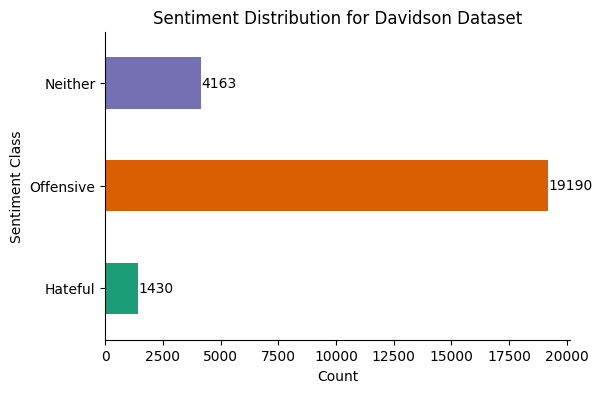

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# Printing a few examples
# Examples where sentiment is hateful
hateful_examples = davidson_df[davidson_df['class'] == 0]['tweet'].head(2).tolist()

# Examples where sentiment is offensive
offensive_examples = davidson_df[davidson_df['class'] == 1]['tweet'].head(2).tolist()

# Examples where sentiment is normal
normal_examples = davidson_df[davidson_df['class'] == 2]['tweet'].head(2).tolist()

print("-------------- Davidson Examples --------------\n")
print("Hate Speech:", hateful_examples)
print("Offensive Language:", offensive_examples)
print("Normal", normal_examples)
print("\n---------------------------------------------\n")

# Assuming df is your DataFrame with 'sentiment' column
sentiment_counts = davidson_df.groupby('class').size()

# Create a horizontal bar plot
ax = sentiment_counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'), figsize=(6, 4))

# Remove the top and right spines
ax.spines[['top', 'right']].set_visible(False)

# Add labels and title
plt.xlabel('Count')
plt.ylabel('Sentiment Class')
plt.title('Sentiment Distribution for Davidson Dataset')

# Add count labels at the end of each bar
for i, count in enumerate(sentiment_counts):
    plt.text(count, i, str(count), ha='left', va='center')

# Modify y-axis tick labels
tick_labels = ['Hateful', 'Offensive', 'Neither']
plt.yticks(range(len(tick_labels)), tick_labels)

# Show the plot
plt.show()

### MLMA Dataset

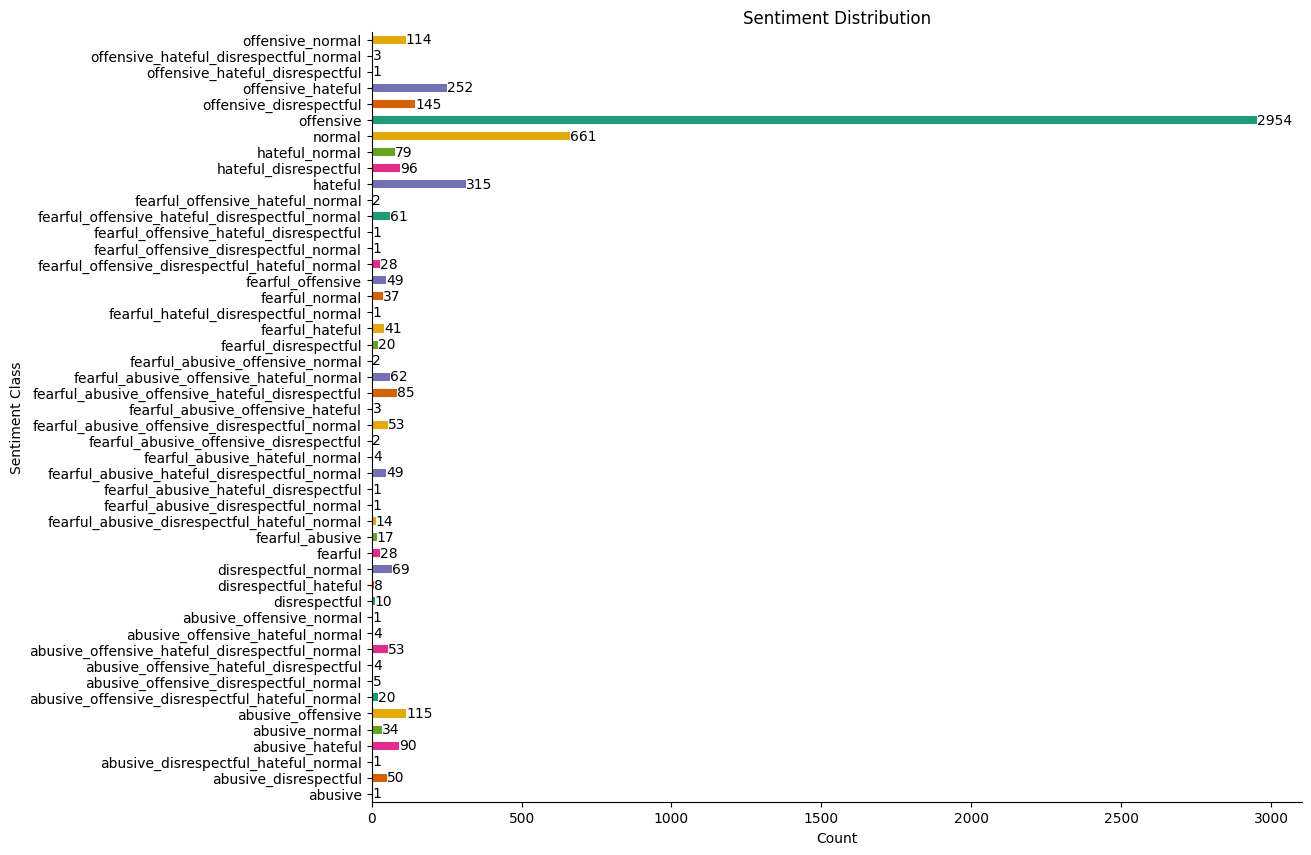

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame with 'sentiment' column
sentiment_counts = mlma_df.groupby('class').size()

# Create a horizontal bar plot
ax = sentiment_counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'), figsize=(12, 10))

# Remove the top and right spines
ax.spines[['top', 'right']].set_visible(False)

# Add labels and title
plt.xlabel('Count')
plt.ylabel('Sentiment Class')
plt.title('Sentiment Distribution')

# Add count labels at the end of each bar
for i, count in enumerate(sentiment_counts):
    plt.text(count, i, str(count), ha='left', va='center')

# Show the plot
plt.show()

# Data Engineering

## Class reorganization for MLMA dataset

Class 0: Hate speech \
Class 1: Offensive language \
Class 2: Neither

In [ ]:
# Define the class to exclude any combination with Normal
class_to_exclude = 'normal'

# Function to check if a class contains the specified class to exclude
def contains_class_to_exclude(class_name):
    return class_to_exclude not in class_name

# Filtering out samples where the 'class' column includes the specified class to exclude
filtered_df = mlma_df[mlma_df['class'].apply(contains_class_to_exclude)]

# Define classes that you want to keep and combinations to exclude
classes_to_keep = ['offensive', 'hateful']

# Function to check if a class is in the specified classes or a combination of them
def keep_class(class_name):
    return any(class_part in class_name for class_part in classes_to_keep)

# Filtering out samples where the 'class' column does not meet the specified conditions
filtered_df_combination = filtered_df[filtered_df['class'].apply(keep_class)]

# Function to check if a class is a combination of two or more specified classes
def is_combination(class_name):
    count = sum(class_part in class_name for class_part in classes_to_keep)
    return count >= 2

# Filtering out samples where the 'class' column is a combination of two or more specified classes
filtered_df_final = filtered_df_combination[~filtered_df_combination['class'].apply(is_combination)]

#Keep only those colums with normal values
normal_df =  mlma_df[mlma_df['class'] == 'normal']

# Concatenate the two filtered DataFrames
result_df = pd.concat([filtered_df_final, normal_df])

# Function to classify the class based on keywords
def classify_class(class_name):
    if 'offensive' in class_name:
        return 'offensive'
    elif 'hateful' in class_name:
        return 'hateful'
    else:
        return 'normal'

# Create a new column 'classification' based on the 'class' column
result_df['class'] = result_df['class'].apply(classify_class)

# Reset the index of the resulting DataFrame
result_df.reset_index(drop=True, inplace=True)

# Map categorical class labels to numerical values (0 for 'hateful', 1 for 'offensive', 2 for 'normal')
result_df['class'] = result_df['class'].replace({'hateful': 0, 'offensive': 1, 'normal': 2})

# Display the DataFrame with the new 'classification' column
mlma_reorg_dataset = result_df.copy()
mlma_reorg_dataset

,tweet,class
0,Most Canadians have never met seen or associat...,1
1,Hahaha grow up faggot @URL,1
2,dude i\u2019m so tired of being retarded,1
3,Pretty sure if an employee of Philip Green cal...,1
4,This bitch Is retarded \ud83d\ude02\ud83d\ude0...,1
...,...,...
4472,Some cunt trying to hack into my twitter!!! Fu...,2
4473,intellectual terrorist,2
4474,@user You seem to care more about illegal immi...,2
4475,@user The helpers are losing the battle and so...,2


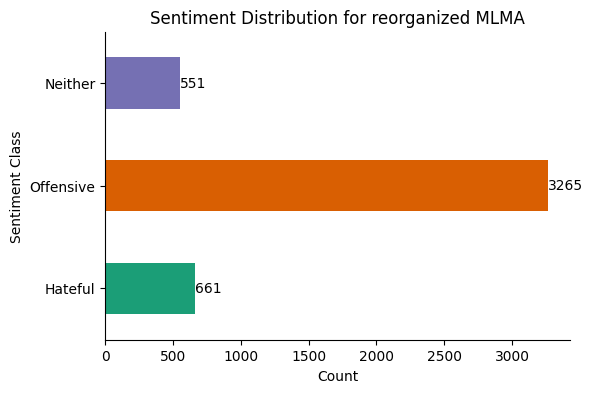

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#finding the sentiments of the dataframe
sentiment_counts = mlma_reorg_dataset.groupby('class').size()

# Create a horizontal bar plot
ax = sentiment_counts[::-1].plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'), figsize=(6, 4))

# Remove the top and right spines
ax.spines[['top', 'right']].set_visible(False)

# Add labels and title
plt.xlabel('Count')
plt.ylabel('Sentiment Class')
plt.title('Sentiment Distribution for reorganized MLMA')

# Add count labels at the end of each bar
for i, count in enumerate(sentiment_counts[::-1]):
    plt.text(count, i, str(count), ha='left', va='center')

# Modify y-axis tick labels to switch the position of 'Hateful' and 'Neither'
tick_labels = ['Neither', 'Offensive', 'Hateful'][::-1]
plt.yticks(range(len(tick_labels)), tick_labels)

# Show the plot
plt.show()

## Combining Data

Before forming the final dataset, we ensured that the 'class' column in two separate dataframes, `davidson_df` and `mlma_reorg_dataset`, is of integer type. Subsequently, we created a dataframe named `neither_df` by concatenating rows from both datasets where the 'class' is equal to 2 (neither class). We then sampled 3000 records from this dataframe. Next, we created a dataframe called `hateful_df` by concatenating rows from both datasets where the 'class' is equal to 0 (hateful class), resulting in 1981 records. Following this, we filtered offensive records from both datasets (`davidson_df` and `mlma_reorg_dataset`) based on a condition related to tweet length, sampled 2000 records from each, and created `offensive_davidson` and `offensive_mlma` dataframes. These were then combined into an `offensive_df`. Finally, we concatenated all three dataframes (`offensive_df`, `neither_df`, and `hateful_df`) into the `combined_df`, and we shuffled the rows for randomness using a random seed of 42. The resulting `combined_df` can be used for training and testing.



In [ ]:
from sklearn.utils import shuffle
import numpy as np

seed_everything()

# Ensure 'class' column is integer
davidson_df['class'] = davidson_df['class'].astype(int)
mlma_reorg_dataset['class'] = mlma_reorg_dataset['class'].astype(int)

# Combine neither classes
neither_df = pd.concat([davidson_df[davidson_df['class'] == 2], mlma_reorg_dataset[mlma_reorg_dataset['class'] == 2]])

# Sample 3000 records from neither_df
neither_df = neither_df.sample(n=3000)
print(f"Number of records labelled Neither: {len(neither_df)}")

# Combine hateful classes
hateful_df = pd.concat([davidson_df[davidson_df['class'] == 0], mlma_reorg_dataset[mlma_reorg_dataset['class'] == 0]])

# We cannot sample 2000 records from hateful_df as only 1981 example are present
# hateful_df = hateful_df.sample(n=2000, replace=True)
print(f"Number of records labelled Hateful: {len(hateful_df)}")

# Filter offensive records with tweet length > 5 from davidson_df
offensive_davidson = davidson_df[(davidson_df['class'] == 1) & (davidson_df['tweet'].str.split().apply(len) > 5)]

# Sample 2000 records from offensive_davidson
offensive_davidson = offensive_davidson.sample(n=2000)

# Filter offensive records with tweet length > 5 from mlma_reorg_dataset
offensive_mlma = mlma_reorg_dataset[(mlma_reorg_dataset['class'] == 1) & (mlma_reorg_dataset['tweet'].str.split().apply(len) > 5)]

# Sample 2000 records from offensive_mlma
offensive_mlma = offensive_mlma.sample(n=2000)

# Combine offensive records from both dataframes
offensive_df = pd.concat([offensive_davidson, offensive_mlma])
print(f"Number of records labelled Offensive: {len(offensive_df)}")

# Combine the dataframes
final_df = pd.concat([offensive_df, neither_df, hateful_df])

# Shuffle the combined dataframe
final_df = shuffle(final_df)

# Reset the index of the resulting DataFrame
final_df.reset_index(drop=True, inplace=True)
print(f"Length of Final Dataset: {len(final_df)}")

# Rename the 'class' column to 'sentiment'
final_df.rename(columns={'class': 'sentiment'}, inplace=True)

# Add a new column 'language' with all values set to 'en'
final_df['language'] = 'en'

# Save the final data
final_df.to_csv("final_data.csv")

final_df

Number of records labelled Neither: 3000
Number of records labelled Hateful: 1981
Number of records labelled Offensive: 4000
Length of Final Dataset: 8981


,tweet,sentiment,language
0,oh well. he's a fag anyways.,0,en
1,@HeilSidious Sion is a faggot. Very meh ganks ...,0,en
2,@MrInfernusHD Squad builders gets you bitches,1,en
3,RT @TheKingScottyD: Side niggas get pussy and ...,1,en
4,RT @WorkoutHumor: These hoes ain't loyal http:...,1,en
...,...,...,...
8976,"I used to get GRs a lot, tho. maybe that's why...",2,en
8977,Did the Italian bird just call Janet a calzone...,2,en
8978,@GoneWithKalijah I watched the 1st season bc I...,1,en
8979,@TechN9ne why did they add your name all ghett...,2,en


## Visualizing Final Data

-------------- Final Dataset Examples --------------

Hate Speech: ["oh well. he's a fag anyways.", "@HeilSidious Sion is a faggot. Very meh ganks pre-6 and post-6 his ganks are still pretty meh he's just a tank, nothing special imo Mao +"]
Offensive Language: ['@MrInfernusHD Squad builders gets you bitches', 'RT @TheKingScottyD: Side niggas get pussy and main niggas get arguments']
Neither ['RT @michaelpshipley: Martin Short On - CONAN - Oct 3, 2014\n\n"With your yellow skin and red hair you look like a #2 pencil."\n\nhttps://t.co/U&#8230;', 'When a once relatively respected &amp; trusted country is turned into a total shithole we need a larger more populate\\u2026 @URL']

---------------------------------------------



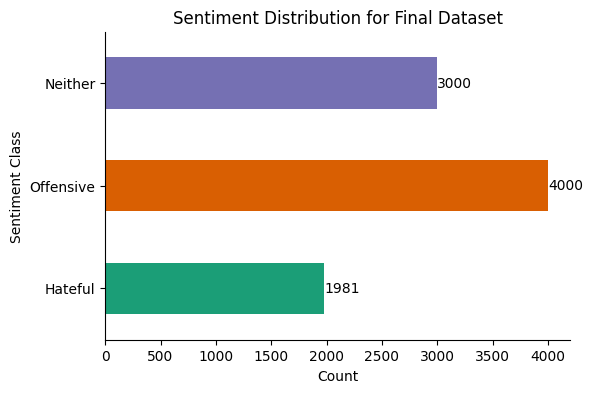

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# Printing a few examples
# Examples where sentiment is hateful
hateful_examples = final_df[final_df['sentiment'] == 0]['tweet'].head(2).tolist()

# Examples where sentiment is offensive
offensive_examples = final_df[final_df['sentiment'] == 1]['tweet'].head(2).tolist()

# Examples where sentiment is normal
normal_examples = final_df[final_df['sentiment'] == 2]['tweet'].head(2).tolist()

print("-------------- Final Dataset Examples --------------\n")
print("Hate Speech:", hateful_examples)
print("Offensive Language:", offensive_examples)
print("Neither", normal_examples)
print("\n---------------------------------------------\n")

# Assuming df is your DataFrame with 'sentiment' column
sentiment_counts = final_df.groupby('sentiment').size()

# Create a horizontal bar plot
ax = sentiment_counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'), figsize=(6, 4))

# Remove the top and right spines
ax.spines[['top', 'right']].set_visible(False)

# Add labels and title
plt.xlabel('Count')
plt.ylabel('Sentiment Class')
plt.title('Sentiment Distribution for Final Dataset')

# Add count labels at the end of each bar
for i, count in enumerate(sentiment_counts):
    plt.text(count, i, str(count), ha='left', va='center')

# Modify y-axis tick labels
tick_labels = ['Hateful', 'Offensive', 'Neither']
plt.yticks(range(len(tick_labels)), tick_labels)

# Show the plot
plt.show()

# Data Preprocessing

## Defining helper functions

The tokenize_and_format function uses bert-base-uncased as the
model for the tokenizer. If we are to use a different model for training or for running predictions in a different notebook or python file, we will need to
to change the model name as well in the tokenizer, otherwise we will get
arbitrarily incorrect results down the line. These functions have been adapted from the pytorch implementation of BERT

In [ ]:
import pandas as pd
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, random_split
from transformers import BertTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import sys
import numpy as np
import time
import datetime

def tokenize_and_format(sentences):
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sentence in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sentence,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 64,           # Pad & truncate all sentences.
                          padding = 'max_length',
                          truncation = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

      # Add the encoded sentence to the list.
      input_ids.append(encoded_dict['input_ids'])

      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])
  return input_ids, attention_masks

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

## Preparing Data

We upload our final data to a dataframe `df`. We have a
function to tokenize and format the data as BERT requires. Make sure that
the csv file, titled final_data.csv, has one column "tweet" and another
column "sentiment" containing integers/float.

In [ ]:
# from helpers import tokenize_and_format, flat_accuracy
import pandas as pd
import numpy as np

seed_everything()

# Read the Final Data
df = pd.read_csv('/content/cs747-noahbert/data/final_data.csv')

texts = df.tweet.values # this assumes that the column containing the text is called "tweet"
labels = df.sentiment.values # this assumes that the column containing the labels is called "class"

### tokenize_and_format() is a helper function provided in helpers.py ###
### Make sure you use the correct model name for your tokenizer! ###
input_ids, attention_masks = tokenize_and_format(texts)

label_list = []
for l in labels:
  label_array = np.zeros(len(set(labels)))
  label_array[int(l)-1] = 1
  label_list.append(label_array)

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(np.array(label_list))

# Print sentence 0, now as a list of IDs.
print('Original: ', texts[0])
print('Token IDs:', input_ids[0])

Original:  oh well. he's a fag anyways.
Token IDs: tensor([ 101, 2821, 2092, 1012, 2002, 1005, 1055, 1037, 6904, 2290, 4312, 2015,
        1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


## Performing Train Test Split

Here we split the dataset into 3 parts: a training set, a validation set, and a testing set. Each item in the dataset will be a 3-tuple containing an input_id tensor, an attention_mask tensor, and a label tensor.

In [ ]:
seed_everything()

total = len(df)

num_train = int(total * .8)
num_val = int(total * .1)
num_test = total - num_train - num_val

# make lists of 3-tuples (already shuffled the dataframe in cell above)
train_set = [(input_ids[i], attention_masks[i], labels[i]) for i in range(num_train)]
val_set = [(input_ids[i], attention_masks[i], labels[i]) for i in range(num_train, num_val+num_train)]
test_set = [(input_ids[i], attention_masks[i], labels[i]) for i in range(num_val + num_train, total)]

train_text = [texts[i] for i in range(num_train)]
val_text = [texts[i] for i in range(num_train, num_val+num_train)]
test_text = [texts[i] for i in range(num_val + num_train, total)]

print(f"Length of Training set: {len(train_text)}")
print(f"Length of Validation set: {len(val_text)}")
print(f"Length of Testing set: {len(test_text)}")

Length of Training set: 7184
Length of Validation set: 898
Length of Testing set: 899


# BERT

## Loading the model

Here we choose the model we want to finetune from https://huggingface.co/transformers/pretrained_models.html. Because the task requires us to label sentences, we wil be using BertForSequenceClassification below. We may see a warning that states that `some weights of the model checkpoint at [model name] were not used when initializing. . .` This warning is expected and means that we should fine-tune our pre-trained model before using it on the downstream task. See [here](https://github.com/huggingface/transformers/issues/5421#issuecomment-652582854) for more info.

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

seed_everything()

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer English BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Defining Hyperparameters

We define our fine-tuning hyperparameters in the cell below

In [ ]:
seed_everything()

batch_size = 45
optimizer = AdamW(model.parameters(),lr=0.00001)
epochs = 50

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Finetuning the model
Here we provide code for fine-tuning the model, monitoring the loss, and checking the validation accuracy.

### Defining function to print validation accuracy

In [ ]:
from transformers import BertTokenizer
import pandas as pd

seed_everything()

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# function to get validation accuracy
def get_validation_performance(val_set):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0

    num_batches = int(len(val_set)/batch_size) + 1

    incorrect_predictions = []
    total_correct = 0
    pred_df = pd.DataFrame(columns=['tweet', 'sentiment', 'language'])

    for i in range(num_batches):

      end_index = min(batch_size * (i+1), len(val_set))

      batch = val_set[i*batch_size:end_index]

      if len(batch) == 0: continue

      input_id_tensors = torch.stack([data[0] for data in batch])
      input_mask_tensors = torch.stack([data[1] for data in batch])
      label_tensors = torch.stack([data[2] for data in batch])

      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)

      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():

        # Forward pass, calculate logit predictions.
        outputs = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask,
                                labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = (logits).detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()


        # Calculate the number of correctly labeled examples in batch
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = np.argmax(label_ids, axis=1).flatten()

        num_correct = np.sum(pred_flat == labels_flat)
        total_correct += num_correct

        for j in range(len(batch)):
          text = tokenizer.decode(batch[j][0], skip_special_tokens=True)
          predicted_label = pred_flat[j]
          actual_label = labels_flat[j]

          if predicted_label != actual_label:
            incorrect_predictions.append((text, predicted_label, actual_label))

          new_row = {'sentence': text, 'predicted_label': predicted_label}
          new_row_df = pd.DataFrame([new_row])

          # Concatenate the DataFrames
          pred_df = pd.concat([pred_df, new_row_df], ignore_index=True)

    # Report the final accuracy for this validation run.
    print("Num of correct predictions during Validation =", total_correct)
    val_accuracy = total_correct / len(val_set)
    return val_accuracy, total_eval_loss, incorrect_predictions, pred_df

### Training and Validating the model

In [ ]:
import random
import numpy as np
seed_everything()

# training loop
epoch_list = []
train_accuracy_list = []
train_loss_list = []
val_accuracy_list = []
val_loss_list = []

# For each epoch...
for epoch_i in range(0, epochs):
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Array for logits
    pred_arr = []
    label_arr = []

    # Put the model into training mode.
    model.train()

    # For each batch of training data...
    num_batches = int(len(train_set)/batch_size) + 1

    for i in range(num_batches):
      end_index = min(batch_size * (i+1), len(train_set))

      batch = train_set[i*batch_size:end_index]

      if len(batch) == 0: continue

      input_id_tensors = torch.stack([data[0] for data in batch])
      input_mask_tensors = torch.stack([data[1] for data in batch])
      label_tensors = torch.stack([data[2] for data in batch])

      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)

      # Perform a forward pass (evaluate the model on this training batch).
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
      loss = outputs.loss
      logits = outputs.logits

      total_train_loss += loss.item()

      # Clear the previously calculated gradient
      model.zero_grad()

      # Perform a backward pass to calculate the gradients.
      loss.backward()

      # Update parameters and take a step using the computed gradient.
      optimizer.step()

      # ========================================
      #       Calculating Train accuracy
      # ========================================
      # Move logits and labels to CPU
      logits = (logits).detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Calculate the number of correctly labeled examples in batch
      pred_flat = np.argmax(logits, axis=1).flatten()
      labels_flat = np.argmax(label_ids, axis=1).flatten()

      pred_arr = np.append(pred_arr, pred_flat)
      label_arr = np.append(label_arr, labels_flat)

    train_accuracy = np.mean(label_arr == pred_arr)
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Total Training loss: {total_train_loss}")

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set. Implement this function in the cell above.
    print("Validating...")
    val_accuracy, val_loss, incorrect_predictions, pred_df = get_validation_performance(val_set)
    print(f"Validation accuracy: {val_accuracy}")
    print(f"Total Validation loss: {val_loss}")

    # Record the training
    epoch_list.append(epoch_i)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(total_train_loss)
    val_accuracy_list.append(val_accuracy)
    val_loss_list.append(val_loss)

print("")
print("Training complete!")


======== Epoch 1 / 50 ========
Training...
Training Accuracy: 0.6101057906458798
Total Training loss: 84.64196386066033
Validating...
Num of correct predictions during Validation = 681
Validation accuracy: 0.7583518930957683
Total Validation loss: 7.9222828396206975

======== Epoch 2 / 50 ========
Training...
Training Accuracy: 0.768652561247216
Total Training loss: 59.46120228077888
Validating...
Num of correct predictions during Validation = 697
Validation accuracy: 0.7761692650334076
Total Validation loss: 6.959744592372194

======== Epoch 3 / 50 ========
Training...
Training Accuracy: 0.8062360801781737
Total Training loss: 51.36167039329979
Validating...
Num of correct predictions during Validation = 709
Validation accuracy: 0.7895322939866369
Total Validation loss: 6.67834877692946

======== Epoch 4 / 50 ========
Training...
Training Accuracy: 0.8278118040089086
Total Training loss: 45.489708988059625
Validating...
Num of correct predictions during Validation = 707
Validation ac

### Plot the train and loss plots per epoch

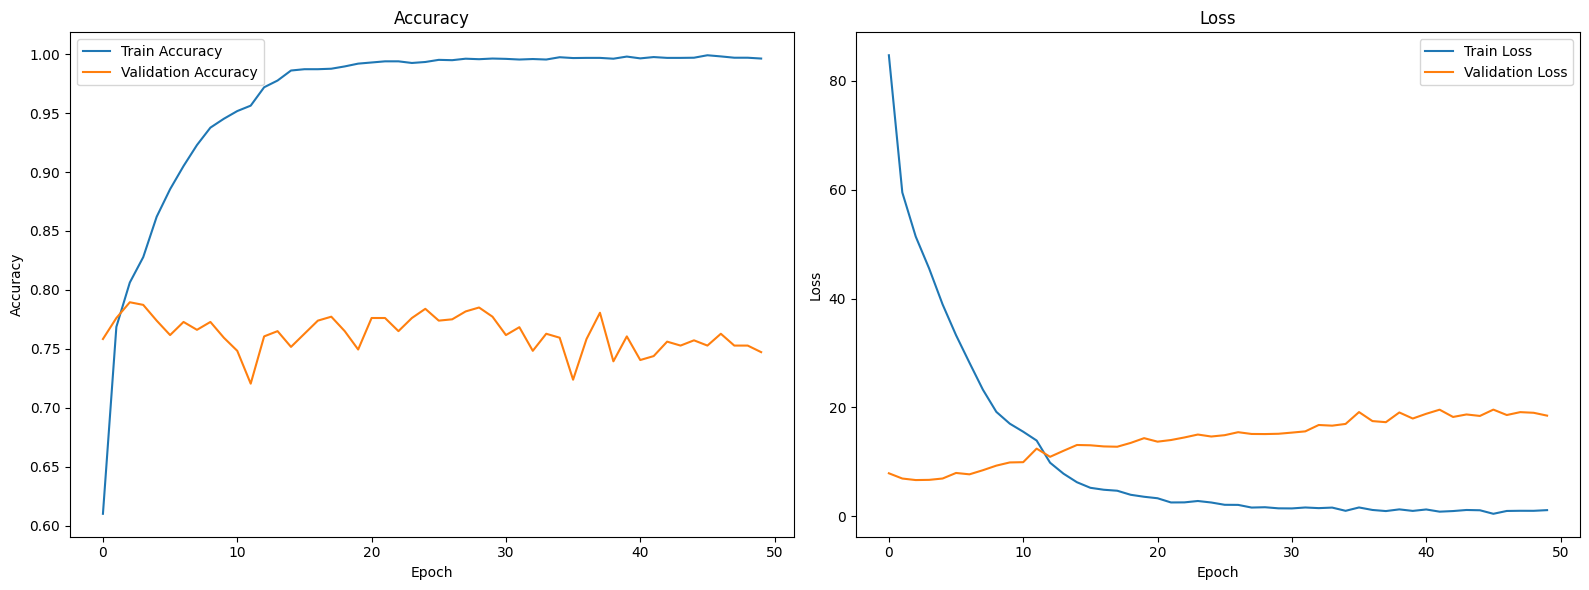

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epoch_list, train_accuracy_list, label="Train Accuracy")
plt.plot(epoch_list, val_accuracy_list, label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epoch_list, train_loss_list, label="Train Loss")
plt.plot(epoch_list, val_loss_list, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

## Saving the model

In [ ]:
from google.colab import files

torch.save(model.state_dict(), "Bert.pth")
files.download('Bert.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Evaluating the model

After tuning the hyperparameters we evaluate our model on the test set

In [ ]:
seed_everything()

# If notebook disconnects during training, then here, first load the best model we saved , then check validation performance

test_accuracy, test_loss, incorrect_predictions, pred_df = get_validation_performance(test_set)
print(test_accuracy)

Num of correct predictions during Validation = 674
0.7497219132369299


## Error Analysis

We perform an *error analysis* on the model. We print out the text of up to five test set examples that our model gets **wrong**. If our model gets more than five test examples wrong, we randomly choose five of them to analyze. If our model gets fewer than five examples wrong, we design five test examples that fool our model (i.e., *adversarial examples*). We then perform a qualitative analysis of these examples to figure out any reasons for errors that we observe, or if we have any informed guesses (e.g., common linguistic properties of these particular examples). We identify any possible future steps to improve the classifier.

In [ ]:
import random
import numpy as np

seed_everything()
torch.cuda.empty_cache()

## print out up to 5 test set examples (or adversarial examples) that model gets wrong
print("Number of incorrect predictions:", len(incorrect_predictions))
random.shuffle(incorrect_predictions)

if len(incorrect_predictions) == 0:
    print("All predictions are correct!")
else:
    print("Below are 5 random incorrect predictions:")
    num_to_print = min(5, len(incorrect_predictions))
    random_indices = np.random.choice(len(incorrect_predictions), size=num_to_print, replace=False)
    for i in random_indices:
        text = incorrect_predictions[i][0]
        print(f'Text: {text}')
        print("Predicted label:", incorrect_predictions[i][1])
        print("Correct label:", incorrect_predictions[i][2])
        print("------------------------------")

Number of incorrect predictions: 207
Below are 5 random incorrect predictions:
Text: @ hovaa _ ok wat ever u say whitey. u prolly never even seen shaft.
Predicted label: 1
Correct label: 2
------------------------------
Text: rt @ alexishope _ 2014 : you got niggas & amp ; i got bitches but i want you... & # 128149 ; & # 127926 ;
Predicted label: 0
Correct label: 2
------------------------------
Text: mike pence out here following the girls? the faggot jumped out!!
Predicted label: 2
Correct label: 0
------------------------------
Text: whenever i hit 1000 followers i feel so self - destructive. like a nigger near a cop car.
Predicted label: 2
Correct label: 1
------------------------------
Text: @ user you can \ u2019t honestly be such an asshole can you? the shithole countries of the past were italy and \ u2026 @ url
Predicted label: 0
Correct label: 2
------------------------------


# NoahBERT

## Load BERT and modify

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer, BertConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers import AdamW, BertConfig

# Load pretrained BERT model and tokenizer
checkpoint = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class BERTWithNoahClassifier(nn.Module):
    """
    Our custom Noah transformer model. This model loads a pre-trained BERT transformer model and adds a new feed-forward, dropout
    and linear layer at the end for fine-tuning and prediction on specific tasks.
    """
    def __init__(self, checkpoint, num_labels ):
        """
        Args:
            checkpoint (str): The name of the pre-trained model or path to the model weights.
            num_labels (int): The number of output labels in the final classification layer.
        """
        super(BERTWithNoahClassifier, self).__init__()
        self.num_labels = num_labels

        self.model = model = BertModel.from_pretrained(checkpoint, config = BertConfig.from_pretrained(checkpoint,
                                                                                                       output_attention = True,
                                                                                                       output_hidden_state = True ) )
        #
        # New Layer
        self.feedforward = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
        )
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(256, num_labels )

    def forward(self, input_ids = None, attention_mask=None, labels = None ):
        """
        Forward pass for the model.

        Args:
            input_ids (torch.Tensor, optional): Tensor of input IDs. Defaults to None.
            attention_mask (torch.Tensor, optional): Tensor for attention masks. Defaults to None.
            labels (torch.Tensor, optional): Tensor for labels. Defaults to None.

        Returns:
            TokenClassifierOutput: A named tuple with the following fields:
            - loss (torch.FloatTensor of shape (1,), optional, returned when label_ids is provided) – Classification loss.
            - logits (torch.FloatTensor of shape (batch_size, num_labels)) – Classification scores before SoftMax.
            - hidden_states (tuple(torch.FloatTensor), optional, returned when output_hidden_states=True is passed or when config.output_hidden_states=True) – Tuple of torch.FloatTensor (one for the output of the embeddings + one for the output of each layer) of shape (batch_size, sequence_length, hidden_size).
            - attentions (tuple(torch.FloatTensor), optional, returned when output_attentions=True is passed or when config.output_attentions=True) – Tuple of torch.FloatTensor (one for each layer) of shape (batch_size, num_heads, sequence_length, sequence_length).
        """
        outputs = self.model(input_ids = input_ids, attention_mask = attention_mask)

        # Extract the last hidden state
        last_hidden_state = outputs.last_hidden_state

        # Apply the feedforward layer
        features = self.feedforward(last_hidden_state[:, 0, :])

        # Apply dropout
        features = self.dropout(features)

        # Apply the classifier layer
        logits = self.classifier(features)

        if labels is not None:
            # Compute the loss if labels are provided
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return logits, loss
        else:
            # Return the logits if no labels are provided
            return logits

# Initialize Noah classifier and combine with BERT model
# noah_classifier = BERTWithNoahClassifier(input_size=768, hidden_size=256, output_size=3)
model = BERTWithNoahClassifier(checkpoint=checkpoint, num_labels=3)

# Tell pytorch to run this model on the GPU.
model.cuda()

BERTWithNoahClassifier(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

## Defining Hyperparameters

In [ ]:
batch_size = 45
optimizer = AdamW(model.parameters(),lr=0.00001)
epochs = 3

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Finetuning NoahBERT

### Defining function to print validation accuracy

In [ ]:
from transformers import BertTokenizer
import pandas as pd
import torch
import numpy as np

seed_everything()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# function to get validation accuracy
def get_validation_performance(val_set, model, batch_size, device):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0

    num_batches = int(len(val_set) / batch_size) + 1

    incorrect_predictions = []
    total_correct = 0
    pred_df = pd.DataFrame(columns=['sentence', 'predicted_label'])

    for i in range(num_batches):
        end_index = min(batch_size * (i + 1), len(val_set))

        batch = val_set[i * batch_size:end_index]

        if len(batch) == 0:
            continue

        input_id_tensors = torch.stack([data[0] for data in batch])
        input_mask_tensors = torch.stack([data[1] for data in batch])
        label_tensors = torch.stack([data[2] for data in batch])


        # Move tensors to the GPU
        b_input_ids = input_id_tensors.to(device)
        b_input_mask = input_mask_tensors.to(device)
        b_labels = label_tensors.to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)
            loss = outputs[1]
            logits = outputs[0]

            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the number of correctly labeled examples in batch
            pred_flat = np.argmax(logits, axis=1).flatten()
            labels_flat = np.argmax(label_ids, axis=1).flatten()

            num_correct = np.sum(pred_flat == labels_flat)
            total_correct += num_correct

            for j in range(len(batch)):
                text = tokenizer.decode(batch[j][0], skip_special_tokens=True)
                predicted_label = pred_flat[j]

                if predicted_label != labels_flat[j]:
                    incorrect_predictions.append((text, predicted_label, labels_flat[j]))

                new_row = {'sentence': text, 'predicted_label': predicted_label}
                new_row_df = pd.DataFrame([new_row])

                # Concatenate the DataFrames
                pred_df = pd.concat([pred_df, new_row_df], ignore_index=True)
    # Report the final accuracy for this validation run.
    print("Num of correct predictions =", total_correct)
    avg_val_accuracy = total_correct / len(val_set)
    return avg_val_accuracy, total_eval_loss, incorrect_predictions, pred_df


###Training and Validating the model

In [ ]:
import torch
import numpy as np

seed_everything()

# training loop
epoch_list = []
train_accuracy_list = []
train_loss_list = []
val_accuracy_list = []
val_loss_list = []

# For each epoch...
for epoch_i in range(0, epochs):
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Array for logits
    pred_arr = []
    label_arr = []

    # Put the model into training mode.
    model.train()

    # For each batch of training data...
    num_batches = int(len(train_set) / batch_size) + 1

    for i in range(num_batches):
        end_index = min(batch_size * (i + 1), len(train_set))

        batch = train_set[i * batch_size:end_index]

        if len(batch) == 0:
            continue

        input_id_tensors = torch.stack([data[0] for data in batch])
        input_mask_tensors = torch.stack([data[1] for data in batch])
        label_tensors = torch.stack([data[2] for data in batch])

        # Move tensors to the GPU
        b_input_ids = input_id_tensors.to(device)
        b_input_mask = input_mask_tensors.to(device)
        b_labels = label_tensors.to(device)

        # Perform a forward pass (evaluate the model on this training batch).
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        logits = outputs[0]
        loss = outputs[1]

        total_train_loss += loss.item()

        # Clear the previously calculated gradient
        model.zero_grad()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

       # ========================================
       #       Calculating Train accuracy
       # ========================================
       # Move logits and labels to CPU
        logits = (logits).detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

       # Calculate the number of correctly labeled examples in batch
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = np.argmax(label_ids, axis=1).flatten()

        pred_arr = np.append(pred_arr, pred_flat)
        label_arr = np.append(label_arr, labels_flat)

    train_accuracy = np.mean(label_arr == pred_arr)
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Total Training loss: {total_train_loss}")


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set. Implement this function in the cell above.
    print(f"Total loss: {total_train_loss}")
    val_acc, val_loss, incorrect_predictions, pred_df = get_validation_performance(val_set, model, batch_size, device)
    print(f"Validation accuracy: {val_acc}")
    print(f"Total Validation loss: {val_loss}")

    # Record the training
    epoch_list.append(epoch_i)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(total_train_loss)
    val_accuracy_list.append(val_acc)
    val_loss_list.append(val_loss)

print("")
print("Noah Training complete!")



======== Epoch 1 / 50 ========
Training...
Training Accuracy: 0.6378062360801782
Total Training loss: 132.74744189669923
Total loss: 132.74744189669923
Num of correct predictions = 679
Validation accuracy: 0.7561247216035635
Total Validation loss: 12.249198343102321

======== Epoch 2 / 50 ========
Training...
Training Accuracy: 0.7742204899777283
Total Training loss: 94.27722238740701
Total loss: 94.27722238740701
Num of correct predictions = 701
Validation accuracy: 0.7806236080178174
Total Validation loss: 11.286748596613876

======== Epoch 3 / 50 ========
Training...
Training Accuracy: 0.8035913140311804
Total Training loss: 82.46431384956551
Total loss: 82.46431384956551
Num of correct predictions = 703
Validation accuracy: 0.7828507795100222
Total Validation loss: 11.068852847262987

======== Epoch 4 / 50 ========
Training...
Training Accuracy: 0.8335189309576837
Total Training loss: 72.32299621028402
Total loss: 72.32299621028402
Num of correct predictions = 701
Validation accur

###Plot the train and loss plots per epoch

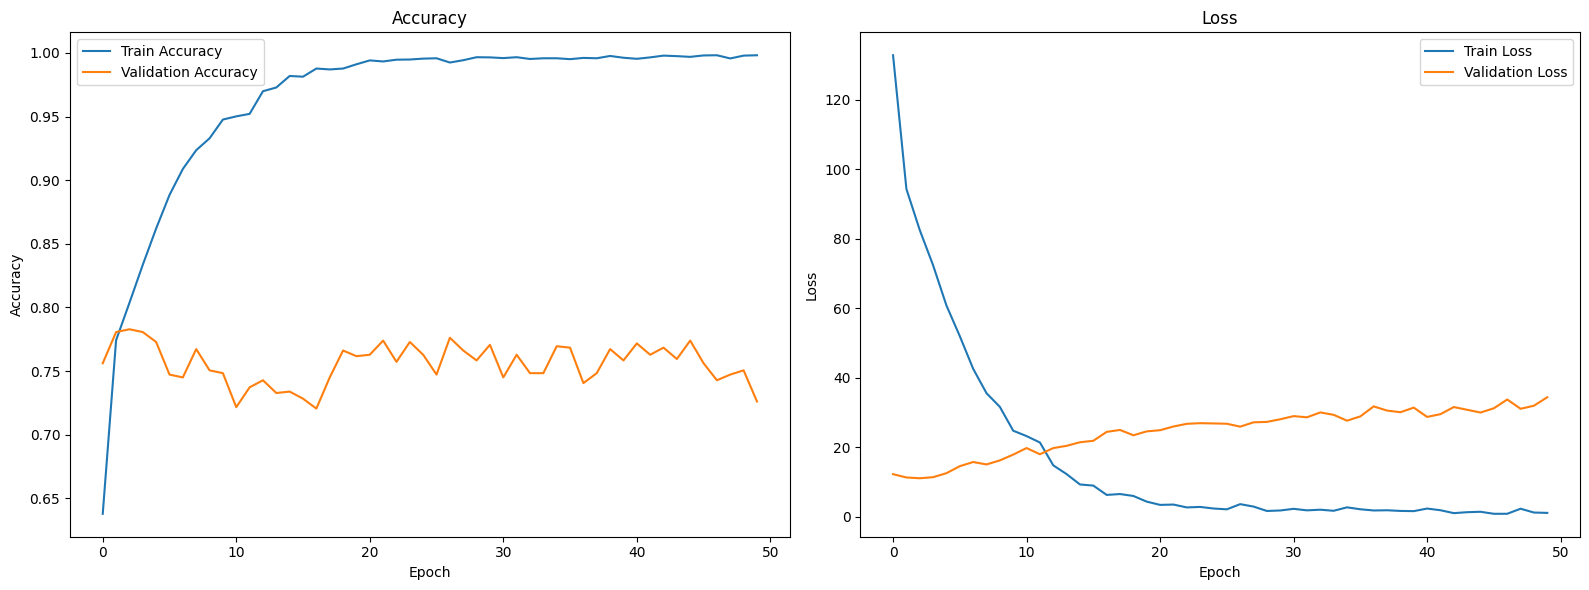

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epoch_list, train_accuracy_list, label="Train Accuracy")
plt.plot(epoch_list, val_accuracy_list, label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epoch_list, train_loss_list, label="Train Loss")
plt.plot(epoch_list, val_loss_list, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

## Saving the model

In [ ]:
from google.colab import files

torch.save(model.state_dict(), "NoahBert.pth")
files.download('NoahBert.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Evaluating the model

In [ ]:
seed_everything()

# If notebook disconnects during training, then here, first load the best model we saved , then check validation performance

test_accuracy, test_loss, incorrect_predictions, pred_df = get_validation_performance(test_set, model, batch_size, device)
print(test_accuracy)

Num of correct predictions = 688
0.7652947719688543


## Error Analysis

In [ ]:
import random
import numpy as np

seed_everything()
torch.cuda.empty_cache()

## print out up to 5 test set examples (or adversarial examples) that model gets wrong
print("Number of incorrect predictions:", len(incorrect_predictions))
random.shuffle(incorrect_predictions)

if len(incorrect_predictions) == 0:
    print("All predictions are correct!")
else:
    print("Below are 5 random incorrect predictions:")
    num_to_print = min(5, len(incorrect_predictions))
    random_indices = np.random.choice(len(incorrect_predictions), size=num_to_print, replace=False)
    for i in random_indices:
        text = incorrect_predictions[i][0]
        print(f'Text: {text}')
        print("Predicted label:", incorrect_predictions[i][1])
        print("Correct label:", incorrect_predictions[i][2])
        print("------------------------------")

Number of incorrect predictions: 211
Below are 5 random incorrect predictions:
Text: @ stephdamartian they made up endearing names for us like nigger spook & amp ; monkey
Predicted label: 2
Correct label: 0
------------------------------
Text: @ user nah b i dont fuck with those ching chong ling long phones
Predicted label: 0
Correct label: 2
------------------------------
Text: the family of ron o'neal needs to sue wu - tang for that trash song they released in his name.
Predicted label: 2
Correct label: 1
------------------------------
Text: @ joebiden is such a retard! & # 8220 ; @ irritatedwoman : biden calls himself & # 8216 ; white boy & # 8217 ; in meeting with black pastors http : / / t. co / bqx1iev0wd & # 8221
Predicted label: 2
Correct label: 0
------------------------------
Text: we should just cancel the shithole countries and just give it to trump
Predicted label: 1
Correct label: 0
------------------------------


# Robustness Test

## Misspelling

In [ ]:
seed_everything()

test_accuracy, test_loss, incorrect_predictions, pred_df = get_validation_performance(test_set, model, batch_size, device)
print(test_accuracy)

Num of correct predictions = 673
0.7186095661846496


## Noise

In [ ]:
seed_everything()

test_accuracy, test_loss, incorrect_predictions, pred_df = get_validation_performance(test_set, model, batch_size, device)
print(test_accuracy)

Num of correct predictions = 669
0.6941601779755283


## Grammar Noise

In [ ]:
seed_everything()

test_accuracy, test_loss, incorrect_predictions, pred_df = get_validation_performance(test_set, model, batch_size, device)
print(test_accuracy)

Num of correct predictions = 671
0.70638487208008898


## Mislabelling

In [ ]:
seed_everything()

test_accuracy, test_loss, incorrect_predictions, pred_df = get_validation_performance(test_set, model, batch_size, device)
print(test_accuracy)

Num of correct predictions = 541
0.59177975528364849


## Robustness Result Graph

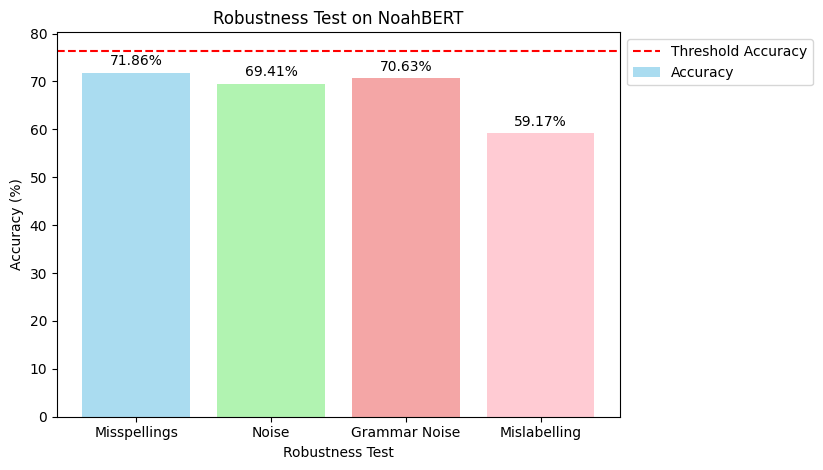

In [ ]:
import matplotlib.pyplot as plt

# Data
categories = ['Misspellings', 'Noise', 'Grammar Noise', 'Mislabelling']
accuracy = [71.86, 69.41, 70.63, 59.17]
threshold_accuracy = 76.43

# Define colors
bar_colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightpink']

# Create bar graph
fig, ax = plt.subplots()
bars = ax.bar(categories, accuracy, color=bar_colors, alpha=0.7, label='Accuracy')
ax.axhline(y=threshold_accuracy, color='red', linestyle='--', label='Threshold Accuracy')

# Title and labels
plt.title('Robustness Test on NoahBERT')
plt.xlabel('Robustness Test')
plt.ylabel('Accuracy (%)')

# Add data labels
for bar, val in zip(bars, accuracy):
    ax.text(bar.get_x() + bar.get_width() / 2, val + 1, f'{val:.2f}%', ha='center', va='bottom', color='black')

# Adjust layout to make room for the legend
plt.tight_layout()

# Show legend with adjusted position
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()
